## Methods to compare in integration tasks

Harmony and Liger are widely-used data integration / batch effect correction methods that have Python implementations. Harmony is usually considered to be less aggressive in strength, thus keeping more biological variance. Liger is suitable in situations with more severe batch effect.

In [1]:
import scanpy as sc
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np

In [22]:
import scib_metrics
from scib_metrics.benchmark import Benchmarker

In [3]:
from tqdm import tqdm

In [4]:
import matplotlib as mpl

## Load data and view the data without integration

In [5]:
methods = ['pca', 'seurat', 'seurat_rpca', 'harmony', 'limma', 'bcd']
sample = 'gse145926'

metadata = pd.read_csv(f"../output-embeddings/{sample}_label.csv", index_col=0)

In [7]:
embs = {}
for m in methods:
    embs[m] = pd.read_csv(f"../output-embeddings/{sample}_{m}.csv", index_col=0)
    if m in ['pca', 'limma']:
        embs[m] = embs[m].iloc[:, :30]
    print(m, embs[m].shape)

pca (65813, 30)
seurat (65813, 30)
seurat_rpca (65813, 30)
harmony (65813, 50)
limma (65813, 30)
bcd (65813, 30)


In [8]:
metadata

,orig.ident,nCount_RNA,nFeature_RNA,ID,sample,sample_new,group,disease,hasnCoV,cluster,celltype,RNA_snn_res.0.5,seurat_clusters,pca_clusters,alt_clusters
AAACCTGAGACACTAA_1,HC1,5228,1635,AAACCTGAGACACTAA_1,C51,HC1,HC,N,N,3,Macrophages,3,3,2,3
AAACCTGAGGAGTACC_1,HC1,5072,1386,AAACCTGAGGAGTACC_1,C51,HC1,HC,N,N,3,Macrophages,3,3,2,3
AAACCTGAGGATATAC_1,HC1,5531,1729,AAACCTGAGGATATAC_1,C51,HC1,HC,N,N,3,Macrophages,3,3,2,3
AAACCTGAGGTCATCT_1,HC1,5630,1639,AAACCTGAGGTCATCT_1,C51,HC1,HC,N,N,3,Macrophages,3,3,2,3
AAACCTGCACGGATAG_1,HC1,7358,1722,AAACCTGCACGGATAG_1,C51,HC1,HC,N,N,5,Macrophages,2,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCGCTTGTC_13,S6,1116,641,TTTGGTTTCGCTTGTC_13,C152,S6,S,Y,N,1,Macrophages,0,0,0,0
TTTGTCAAGAAACGCC_13,S6,12872,3510,TTTGTCAAGAAACGCC_13,C152,S6,S,Y,N,14,T,9,9,10,9
TTTGTCACAACACCCG_13,S6,1347,556,TTTGTCACAACACCCG_13,C152,S6,S,Y,N,19,Plasma,13,13,12,13
TTTGTCAGTCTGCAAT_13,S6,21275,3374,TTTGTCAGTCTGCAAT_13,C152,S6,S,Y,N,19,Plasma,13,13,12,13


## Scoring and plotting 

In [9]:
label = 'celltype'
batch = "sample_new"
use_cosine = []

In [10]:
ct = pd.crosstab(metadata[label], metadata[batch])
ct

sample_new,HC1,HC2,HC3,HC4,M1,M2,M3,S1,S2,S3,S4,S5,S6
celltype,,,,,,,,,,,,,
B,15,5,9,22,35,24,8,34,28,2,4,28,6
Epithelial,13,33,13,1383,83,94,38,368,309,312,373,185,327
Macrophages,7915,7943,1998,683,2177,2060,116,9829,12765,635,1087,1062,1147
Mast,0,0,6,19,2,2,2,8,13,0,6,8,4
NK,5,1,62,29,130,139,29,178,357,8,21,80,42
Neutrophil,0,0,0,0,2,1,1,412,829,257,31,50,24
Plasma,1,0,2,0,11,2,1,27,162,4,13,4,814
T,272,53,367,533,981,1008,146,703,2272,62,155,638,526
mDC,230,115,103,37,85,55,19,161,116,12,25,14,6


In [17]:
adata.obsm[matrix_name]

array([[ 3.14067275e+00,  1.81815326e+00,  5.61983729e+00, ...,
        -6.04068589e-01, -8.87116452e-01, -2.89644875e-01],
       [ 3.69706760e+00,  1.78740843e+00,  4.87162870e+00, ...,
         5.21137750e-01,  6.15169966e-01,  7.74346098e-01],
       [ 3.32775739e+00,  1.55973050e+00,  6.13096529e+00, ...,
        -1.19943686e-01,  9.18172234e-01, -2.50409003e-01],
       ...,
       [ 2.79473239e+00, -4.92708820e-03, -7.20070795e+00, ...,
        -2.04362106e+00, -6.95071405e-01, -1.51936779e+00],
       [ 1.12012222e+00, -5.09976827e-01, -1.23625153e+01, ...,
        -2.49770669e+00, -3.96049916e+00, -3.63738744e-01],
       [ 3.33263114e+00,  4.47908586e-01, -7.89724300e+00, ...,
         2.31082803e-01, -6.44967409e-03, -2.39018894e+00]])

In [18]:
scores = {}

for m in tqdm(methods):
    matrix_name = 'X_' + m
    
    adata = sc.AnnData(np.zeros([embs[m].shape[0], 0]), obs=metadata)
    adata.obsm[matrix_name] = embs[m]
    
    s = scib_metrics.silhouette_label(adata.obsm[matrix_name].to_numpy(), metadata[label])
    db = 0# skl.metrics.davies_bouldin_score(embs[m], metadata[label])
    ch = 0#skl.metrics.calinski_harabasz_score(embs[m], metadata[label])
    ilasw = scib_metrics.isolated_labels(adata.obsm[matrix_name].to_numpy(), metadata[label], metadata[batch])
    sb = scib_metrics.silhouette_batch(adata.obsm[matrix_name].to_numpy(), metadata[label], metadata[batch])
    
    scores[m] = [s, db, ch, ilasw, sb]
    
    # matrix_name = 'X_' + method
    
    # if method in use_cosine:
    #     sc.pp.neighbors(adata, use_rep=matrix_name, metric='cosine')
    # else:
    #     sc.pp.neighbors(adata, use_rep=matrix_name)
    
    # ilasw = scib.me.isolated_labels_asw(adata, batch_key=batch, label_key=label, embed=matrix_name)
    # ilf1 = scib.me.isolated_labels_f1(adata, batch_key=batch, label_key="cell_type", embed=None)
    # clisi = scib.me.clisi_graph(adata, label_key=label, type_="knn")
    
    # scores[m] = [s, db, ch, ilasw, ilf1, clisi]

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [19:13<00:00, 192.32s/it]


In [19]:
# scores = pd.DataFrame(scores, index=['silhouette', 'davies_bouldin', 'calinski_harabasz', 'ilasw', 'ilf1', 'cLISI']).T
scores = pd.DataFrame(scores, index=['silhouette', 'davies_bouldin', 'calinski_harabasz', 'silhouette_celltype', 'silhouette_batch']).T
scores

,silhouette,davies_bouldin,calinski_harabasz,silhouette_celltype,silhouette_batch
pca,0.540193,0.0,0.0,0.622682,0.821706
seurat,0.601251,0.0,0.0,0.602077,0.809521
seurat_rpca,0.576352,0.0,0.0,0.595320,0.802960
harmony,0.555705,0.0,0.0,0.612252,0.829921
limma,0.575930,0.0,0.0,0.559005,0.791675
bcd,0.551133,0.0,0.0,0.569027,0.828814


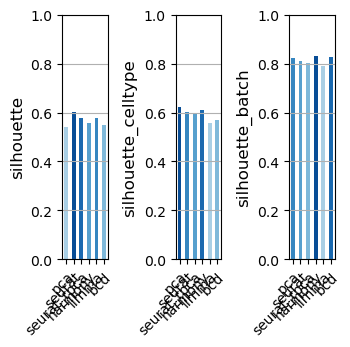

In [21]:
cmap = mpl.colormaps['Blues']
lower_is_better = ['davies_bouldin', '']
benchmarks = ['silhouette',  'silhouette_celltype', 'silhouette_batch']

plt.subplots(1, len(benchmarks), figsize=(3.5, 3.5))
for i, v in enumerate(benchmarks):
    ax = plt.subplot(1, len(benchmarks), i + 1)
    color = mpl.colormaps['Blues'](1 - scores[v].rank(ascending=v in lower_is_better, pct=True) * .66)
    scores[v].plot(kind='bar', color=color)
    plt.ylabel(v, size=12)
    plt.grid(axis='y')
    
    plt.xticks(rotation=45, ha='right', va='top', rotation_mode='anchor', size=10)
    
    dmin = scores[v].min()
    dmax = scores[v].max()
    
    if dmin >= 0.0 and dmin <= 1.0 and dmax >= 0.0 and dmax <= 1.0:
        for vmin in [5000, 0.0]:
            if dmin > vmin:
                break
        for vmax in [0.5, 1.0]:
            if dmax < vmax:
                break
        plt.ylim(vmin, vmax)
        
    if v in lower_is_better:
        plt.gca().invert_yaxis()
    if v == 'calinski_harabasz':
        plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.yticks(size=10)
    ax.yaxis.get_offset_text().set_fontsize(10)
plt.tight_layout(pad=0.8)

In [23]:
data = sc.read_mtx("../data/COVID-19/merged_counts.mtx")

ValueError: Length of passed value for obs_names is 65813, but this AnnData has shape: (33539, 65813)

In [24]:
data = data.T

In [32]:
data.obs = pd.read_csv(f"../output-embeddings/{sample}_label.csv", index_col=0)

In [26]:
data.var = pd.read_csv("../data/COVID-19/features.csv", index_col=0)

In [35]:
adata = data[metadata.index, :]
metadata.index = metadata.index.str.replace('_', '.')
adata.obs = metadata
for m in tqdm(methods):
    matrix_name = m
    adata.obsm[matrix_name] = embs[m].to_numpy()

C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\anndata\_core\anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 6004.73it/s]


In [38]:
from scib_metrics.benchmark import BioConservation, BatchCorrection
bm = Benchmarker(
    adata,
    batch_key=batch,
    label_key=label,
    embedding_obsm_keys=['pca', 'seurat', 'seurat_rpca', 'harmony', 'limma', 'bcd'],
    bio_conservation_metrics=BioConservation(isolated_labels=True, nmi_ari_cluster_labels_leiden=False, nmi_ari_cluster_labels_kmeans=False, silhouette_label=True, clisi_knn=False),
    batch_correction_metrics=BatchCorrection(silhouette_batch=True, ilisi_knn=False, kbet_per_label=False, graph_connectivity=True, pcr_comparison=False),
    n_jobs=6,
)
bm.benchmark()

Metrics:  30%|██████████▊                         | 3/10 [00:38<01:24, 12.03s/it, Batch correction: graph_connectivity]C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\scib_metrics\_graph_connectivity.py:27: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Metrics:   0%|                                                                                  | 0/10 [00:00<?, ?it/s]
                                                                                                                       
Metrics:  30%|██████████▊                         | 3/10 [00:37<01:22, 11.79s/it, Batch correction: graph_connectivity]C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\scib_metrics\_graph_connectivity.py:27: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.valu

Metrics:   0%|                                                                                  | 0/10 [00:00<?, ?it/s]
                                                                                                                       
Metrics:  30%|██████████▊                         | 3/10 [00:51<01:54, 16.37s/it, Batch correction: graph_connectivity]C:\Users\lshh\miniconda3\envs\py39_integration\lib\site-packages\scib_metrics\_graph_connectivity.py:27: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)

Embeddings: 100%|███████████████████████████████████████████████████████████████████████| 6/6 [17:06<00:00, 171.08s/it]

                                                                                                                       

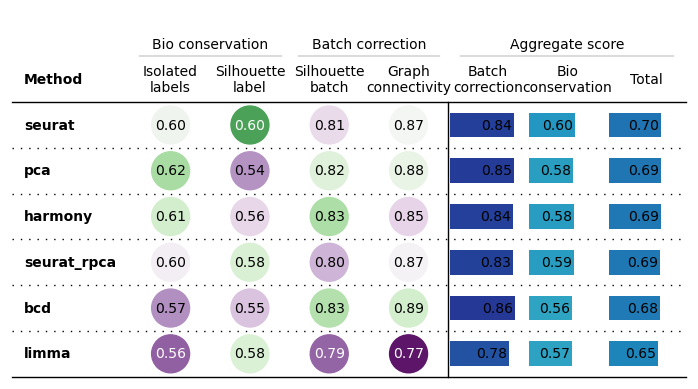

In [39]:
bm.plot_results_table(min_max_scale=False)